To run this notebook, you must first download data from [this repo](https://github.com/RaptorMaps/InfraredSolarModules) and save the images into an /images/ folder.

### **Prepare Data** 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import json
import os
import random
import tensorflow as tf

In [2]:
os.listdir('./')

['app.ipynb',
 'holdout_set.docx',
 'Data_exploration.ipynb',
 '.ipynb_checkpoints',
 'requirements.txt',
 'holdout_set.txt',
 'runtime.txt',
 'README.md',
 'CNN_classifier.ipynb',
 'Procfile',
 'images.zip',
 'images',
 'module_metadata.json',
 '.git',
 'venv']

In [3]:
with open("./module_metadata.json", 'r') as read_file:
    data = json.load(read_file)

In [4]:
df_files = pd.DataFrame(data)
df_files.head()

13357             13356             19719  \
image_filepath  images/13357.jpg  images/13356.jpg  images/19719.jpg   
anomaly_class         No-Anomaly        No-Anomaly        No-Anomaly   

                           11542             11543             11540  \
image_filepath  images/11542.jpg  images/11543.jpg  images/11540.jpg   
anomaly_class         No-Anomaly        No-Anomaly        No-Anomaly   

                           11541             11546             11547  \
image_filepath  images/11541.jpg  images/11546.jpg  images/11547.jpg   
anomaly_class         No-Anomaly        No-Anomaly        No-Anomaly   

                           11544  ...             8483             8484  \
image_filepath  images/11544.jpg  ...  images/8483.jpg  images/8484.jpg   
anomaly_class         No-Anomaly  ...       Vegetation       Vegetation   

                           8485             8486             8487  \
image_filepath  images/8485.jpg  images/8486.jpg  images/8487.jpg   
anomaly_class        Vegetation       Vegetation       Vegetation   

                           8488             8489             7464  \
image_filepath  images/8488.jpg  images/8489.jpg  images/7464.jpg   
anomaly_class        Vegetation       Vegetation         Cracking   

                           18065             13354  
image_filepath  images/18065.jpg  images/13354.jpg  
anomaly_class         No-Anomaly        No-Anomaly  

[2 rows x 19903 columns]

In [5]:
def loadFiles(data):
    new_df = []
    for file in data.iloc[0]:
        img_data = img.imread(file)
        new_df.append(img_data / 255)
    return np.array(new_df)

In [6]:
X = loadFiles(df_files)
X

array([[[0.55294118, 0.57647059, 0.61568627, ..., 0.60392157,
         0.58039216, 0.55294118],
        [0.55686275, 0.58431373, 0.62352941, ..., 0.59215686,
         0.56862745, 0.54509804],
        [0.56078431, 0.58823529, 0.63137255, ..., 0.60392157,
         0.58431373, 0.56470588],
        ...,
        [0.54509804, 0.54509804, 0.57647059, ..., 0.58039216,
         0.57254902, 0.54509804],
        [0.50980392, 0.51372549, 0.54117647, ..., 0.53333333,
         0.5254902 , 0.49411765],
        [0.45490196, 0.45490196, 0.4745098 , ..., 0.45882353,
         0.44705882, 0.41568627]],

       [[0.38823529, 0.37254902, 0.35686275, ..., 0.64705882,
         0.64705882, 0.64313725],
        [0.40392157, 0.39607843, 0.38823529, ..., 0.62745098,
         0.64313725, 0.65098039],
        [0.45882353, 0.45098039, 0.45098039, ..., 0.6       ,
         0.62352941, 0.63921569],
        ...,
        [0.56862745, 0.57254902, 0.58431373, ..., 0.61176471,
         0.58823529, 0.56862745],
        [0.5

In [7]:
y = df_files.iloc[1]
y.to_numpy()

array(['No-Anomaly', 'No-Anomaly', 'No-Anomaly', ..., 'Cracking',
       'No-Anomaly', 'No-Anomaly'], dtype=object)

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [9]:
le = LabelEncoder()
le.fit(['No-Anomaly', 'Cell', 'Cell-Multi', 'Cracking', 'Diode', 'Diode-Multi', 'Hot-Spot', 'Hot-Spot-Multi', 'Offline-Module', 'Shadowing', 'Soiling', 'Vegetation'])
labels = le.transform(y)
classes = dict(enumerate(le.classes_))
print(classes)

{0: 'Cell', 1: 'Cell-Multi', 2: 'Cracking', 3: 'Diode', 4: 'Diode-Multi', 5: 'Hot-Spot', 6: 'Hot-Spot-Multi', 7: 'No-Anomaly', 8: 'Offline-Module', 9: 'Shadowing', 10: 'Soiling', 11: 'Vegetation'}


### **Create Model** 

In [10]:
img_rows, img_cols = 40, 24
image_shape = (40, 24, 1)
num_classes = 12

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D

def classificationModel(filters_list, nodes_list, conv_filter_size, pool_filter_size, activation_list, dropout):

    model = Sequential()
    model.add(Conv2D(filters_list[0], conv_filter_size, activation=activation_list[0], padding='same', input_shape=image_shape))
    model.add(MaxPooling2D(pool_size=pool_filter_size, padding='same'))
    model.add(Conv2D(filters_list[1], conv_filter_size, activation=activation_list[0]))
    model.add(MaxPooling2D(pool_size=pool_filter_size))
  #  model.add(Conv2D(filters_list[2], conv_filter_size, activation=activation_list[0]))
  #  model.add(MaxPooling2D(pool_size=pool_filter_size))
    model.add(Flatten())
    model.add(Dense(nodes_list[0], activation=activation_list[0]))
    model.add(Dense(nodes_list[1], activation=activation_list[0]))
    model.add(Dropout(dropout))
    model.add(Dense(nodes_list[2], activation=activation_list[1]))
    
    return model
    

In [12]:
model = classificationModel([20, 32, 48], [192, 48, num_classes], (1), (2), ['relu', 'softmax'], 0.25)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 40, 24, 20)        40        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 12, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 12, 32)        672       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 6, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 192)               368832    
_________________________________________________________________
dense_1 (Dense)              (None, 48)                9

In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['AUC'])

In [14]:
batch_size = 32
epochs = 8

### **Train Model**

Cross-validation done using the stratified K-fold method

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [16]:
skf = StratifiedKFold()
skf.get_n_splits(X,y)

5

In [17]:
histories = []
predictions = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print(X_train.shape, y_train.shape)
    histories.append(model.fit(tf.expand_dims(X_train,-1), to_categorical(le.transform(y_train)), batch_size, epochs, 
                                validation_data=(tf.expand_dims(X_test,-1), to_categorical(le.transform(y_test)))))
    predictions.append(model.predict(tf.expand_dims(X_test,-1)))

(15922, 40, 24) (15922,)
Epoch 1/8
498/498 [==============================] - 5s 11ms/step - loss: 1.8274 - auc: 0.8099 - val_loss: 1.7409 - val_auc: 0.8321
Epoch 2/8
498/498 [==============================] - 5s 11ms/step - loss: 1.7539 - auc: 0.8310 - val_loss: 1.7115 - val_auc: 0.8443
Epoch 3/8
498/498 [==============================] - 5s 10ms/step - loss: 1.7112 - auc: 0.8437 - val_loss: 1.6496 - val_auc: 0.8599
Epoch 4/8
498/498 [==============================] - 5s 10ms/step - loss: 1.6417 - auc: 0.8594 - val_loss: 1.5560 - val_auc: 0.8775
Epoch 5/8
498/498 [==============================] - 5s 10ms/step - loss: 1.5577 - auc: 0.8749 - val_loss: 1.4919 - val_auc: 0.8899
Epoch 6/8
498/498 [==============================] - 5s 10ms/step - loss: 1.4882 - auc: 0.8865 - val_loss: 1.4064 - val_auc: 0.9000
Epoch 7/8
498/498 [==============================] - 5s 10ms/step - loss: 1.4400 - auc: 0.8943 - val_loss: 1.3874 - val_auc: 0.9033
Epoch 8/8
498/498 [==============================] 

### **Evaluate Results**

In [18]:
def plotmetric(history, metric):
    plt.title("Model "+metric.title())
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])
    plt.xlabel('epoch')
    plt.ylabel('metric')
    #plt.ylim([0,1])
    plt.show()

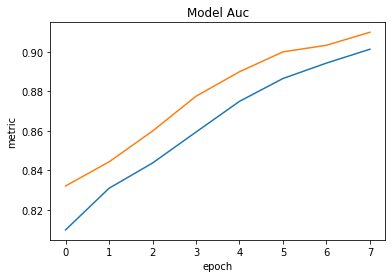

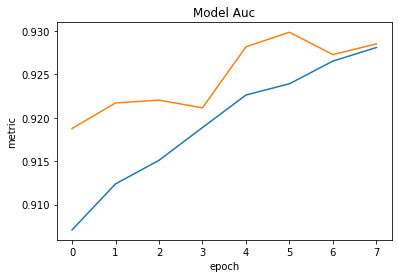

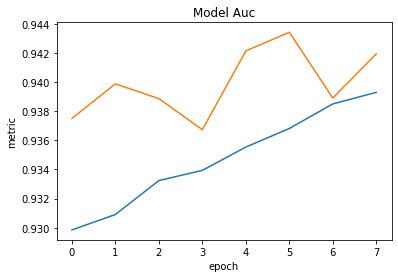

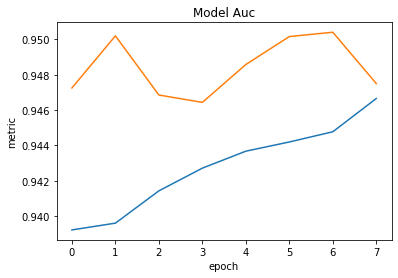

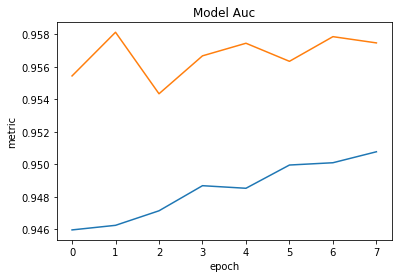

In [19]:
for history in histories:
    plotmetric(history, 'auc')

In [20]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report,multilabel_confusion_matrix

In [21]:
def plot_roc_curve(y_true, y_pred, n):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(classes.get(n))
    plt.legend()
    plt.show()

In [23]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

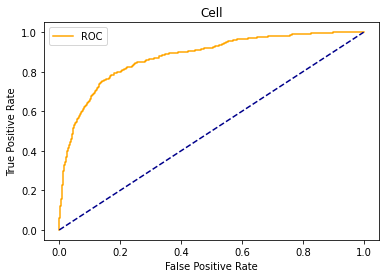

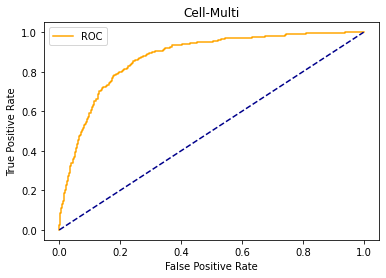

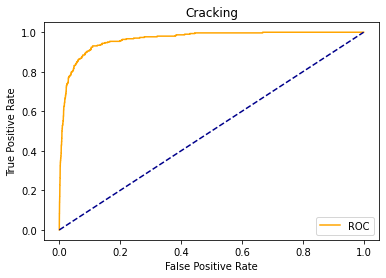

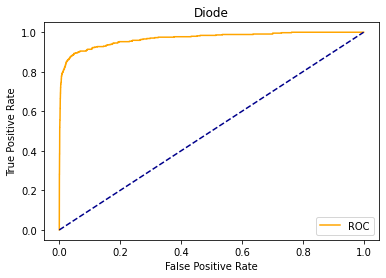

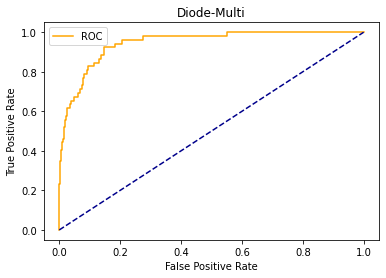

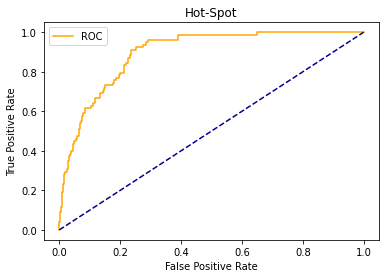

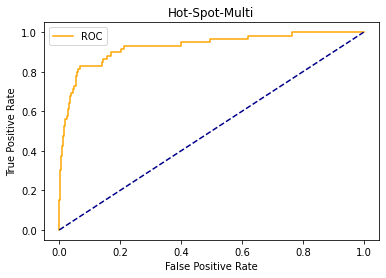

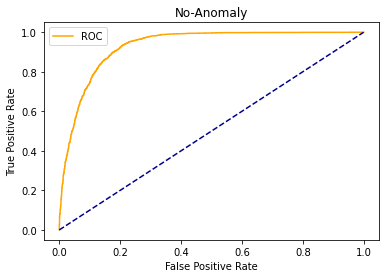

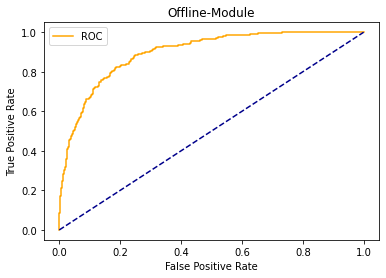

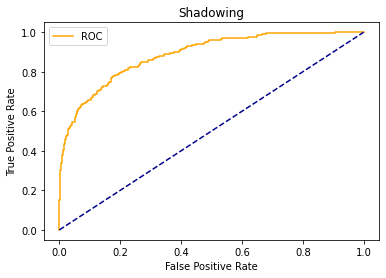

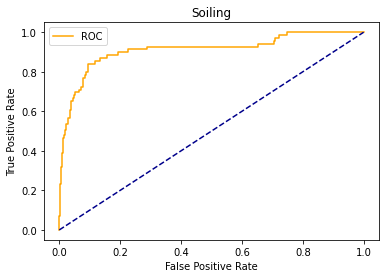

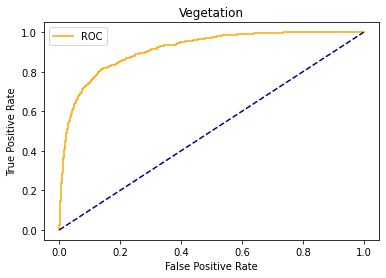

In [24]:
pred_proba = model.predict(tf.expand_dims(x_test,-1))
for n in classes.keys():
    plot_roc_curve(to_categorical(le.transform(y_test))[:,n], pred_proba[:,n], n)
    

In [25]:
y_pred = (pred_proba > 0.5)
print(classification_report(to_categorical(le.transform(y_test)),y_pred))

              precision    recall  f1-score   support

           0       0.70      0.21      0.33       591
           1       0.71      0.02      0.05       407
           2       0.72      0.53      0.61       304
           3       0.91      0.75      0.82       441
           4       1.00      0.10      0.18        52
           5       0.00      0.00      0.00        78
           6       0.67      0.03      0.06        59
           7       0.84      0.87      0.86      2934
           8       0.82      0.10      0.18       221
           9       0.90      0.22      0.35       317
          10       0.00      0.00      0.00        69
          11       0.69      0.39      0.50       498

   micro avg       0.82      0.58      0.68      5971
   macro avg       0.66      0.27      0.33      5971
weighted avg       0.79      0.58      0.62      5971
 samples avg       0.58      0.58      0.58      5971



/home/david/voila/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/david/voila/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
multilabel_confusion_matrix(to_categorical(le.transform(y_test)),y_pred)

array([[[5325,   55],
        [ 464,  127]],

       [[5560,    4],
        [ 397,   10]],

       [[5603,   64],
        [ 143,  161]],

       [[5498,   32],
        [ 112,  329]],

       [[5919,    0],
        [  47,    5]],

       [[5893,    0],
        [  78,    0]],

       [[5911,    1],
        [  57,    2]],

       [[2553,  484],
        [ 379, 2555]],

       [[5745,    5],
        [ 198,   23]],

       [[5646,    8],
        [ 247,   70]],

       [[5902,    0],
        [  69,    0]],

       [[5385,   88],
        [ 305,  193]]])

In [27]:
score = roc_auc_score(to_categorical(le.transform(y_test)), pred_proba, multi_class='ovo')
print(score)

0.9154106173784092


In [28]:
def predict_image_by_indx(i):
    holdout_image = X[i]
    prob = model.predict(holdout_image.reshape(1, 40, 24, 1))
    plt.imshow(holdout_image)
    pred = prob > 0.5
    print(pred[0])
    n = le.classes_[pred[0]]
    print(n)
    plt.title("Predicted: " + n[0] + "\nActual: "+y[i])

[False False False  True False False False False False False False False]
['Diode']


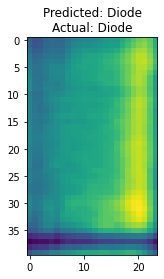

In [29]:
predict_image_by_indx(8483)

In [30]:
#!mkdir -p saved_model
model.save('saved_model/CNN_1')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/CNN_1/assets
